In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/dogscats/"
!ls {PATH}valid

cats  dogs


In [4]:
sz = 224

In [5]:
files = !ls {PATH}valid/cats | head

In [6]:
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

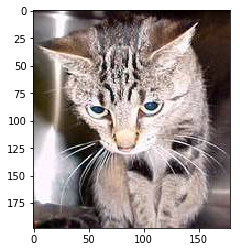

In [7]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [8]:
arch = resnet34
data = ImageClassifierData?

In [ ]:
data = ImageClassifierData

In [9]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

100%|██████████| 32/32 [00:22<00:00,  1.41it/s]


A Jupyter Widget

  4%|▍         | 14/360 [00:00<00:19, 17.47it/s, loss=0.177]

/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.       0.04782  0.03188  0.98877]                         
[ 1.       0.03886  0.02916  0.98682]                         
[ 2.       0.03948  0.03042  0.9873 ]                          



In [10]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [11]:
np.shape(data.val_y)

(2000,)

In [12]:
data.classes

['cats', 'dogs']

In [13]:
log_preds = learn.predict()
log_preds.shape

/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(2000, 2)

In [14]:
log_preds[:10]

array([[ -0.00006,  -9.65155],
       [ -0.00003, -10.40269],
       [ -0.00002, -10.9969 ],
       [ -0.00003, -10.33477],
       [ -0.00171,  -6.37194],
       [ -0.00001, -11.40996],
       [ -0.00004, -10.16625],
       [ -0.     , -13.80192],
       [ -0.00002, -11.01098],
       [ -0.00005,  -9.85996]], dtype=float32)

In [15]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

In [16]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y) == is_correct)

In [17]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [18]:
def plots(ims, figsize=(12, 6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
            plt.imshow(ims[i])

In [19]:
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16, 8))

correctly classified


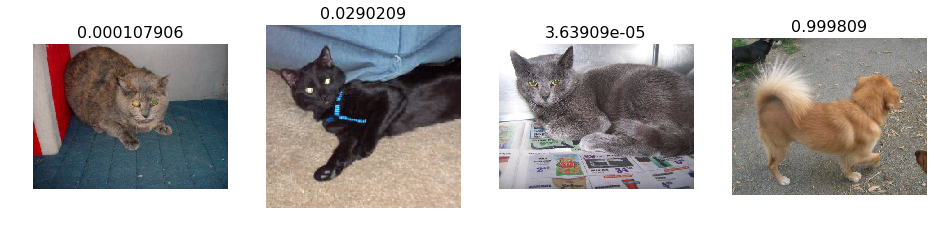

In [20]:
plot_val_with_title(rand_by_correct(True), "correctly classified")

Incorrectly classified


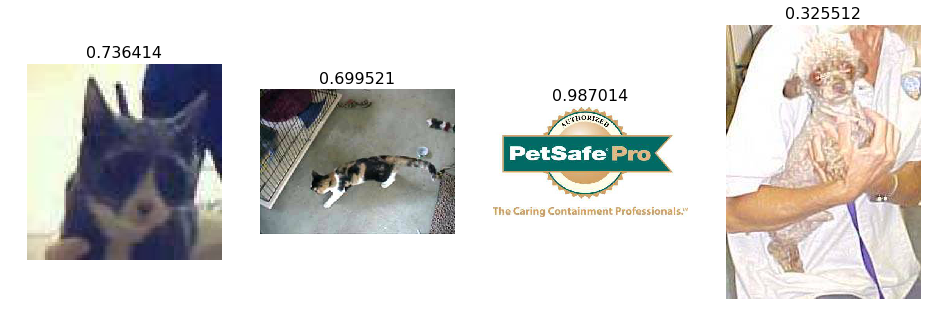

In [21]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [22]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y == 1) == is_correct else 1
    return most_by_mask((preds == data.val_y) == is_correct & (data.val_y == y), mult)

Most correct cats


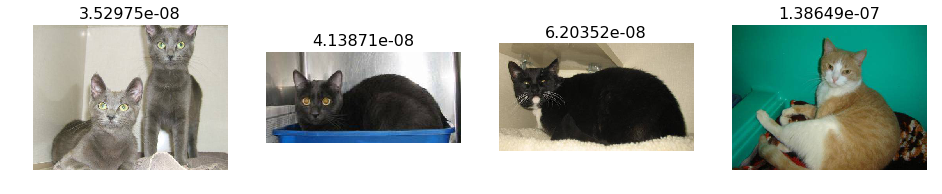

In [23]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


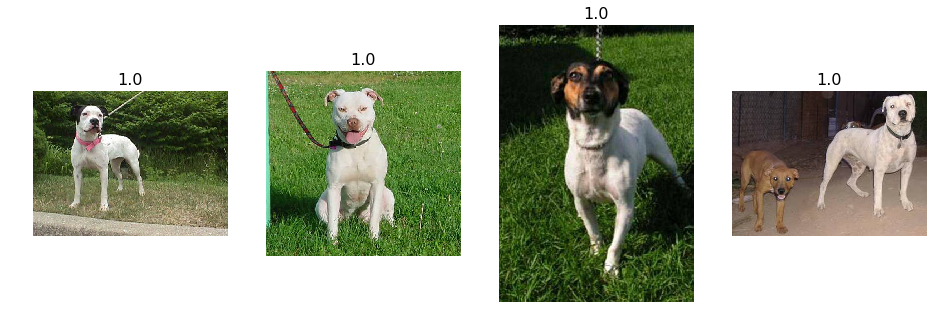

In [24]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect dogs


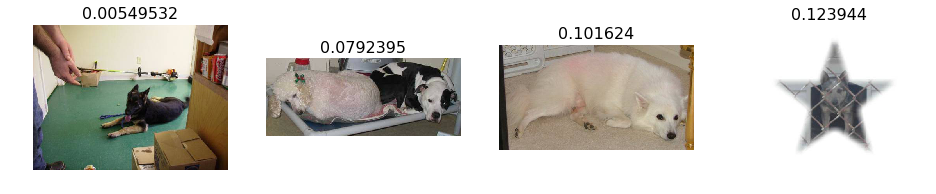

In [25]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most incorrect cats


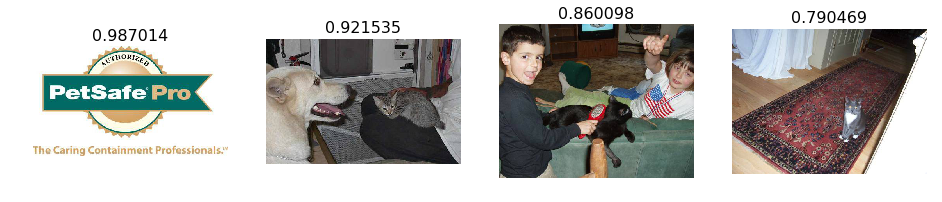

In [26]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most uncertain predictions


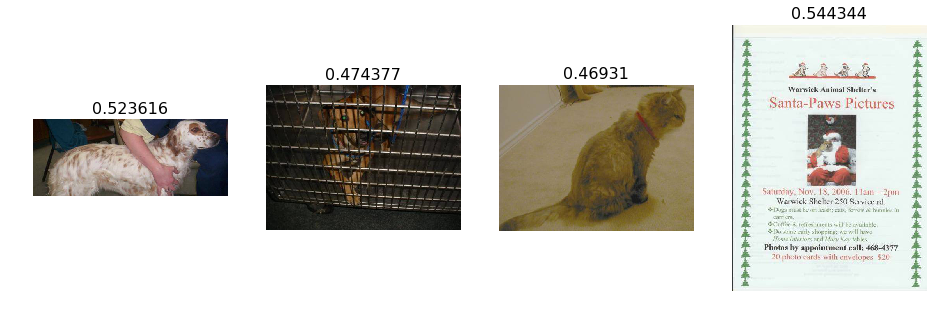

In [27]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [28]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf = learn.lr_find()

A Jupyter Widget

  5%|▌         | 18/360 [00:00<00:08, 38.81it/s, loss=0.805]

/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 83%|████████▎ | 298/360 [00:02<00:00, 133.63it/s, loss=0.447]


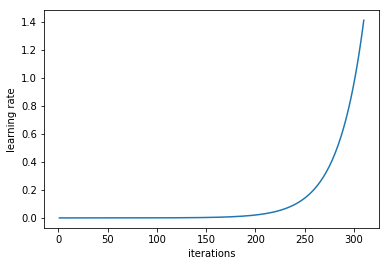

In [29]:
learn.sched.plot_lr()

In [30]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

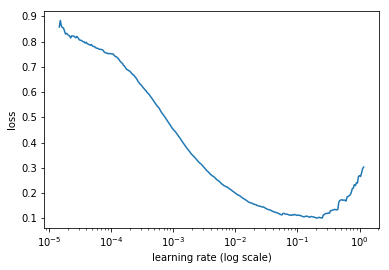

In [31]:
learn.sched.plot()

In [32]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=4)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [35]:
ims = np.stack([get_augs() for i in range(6)])

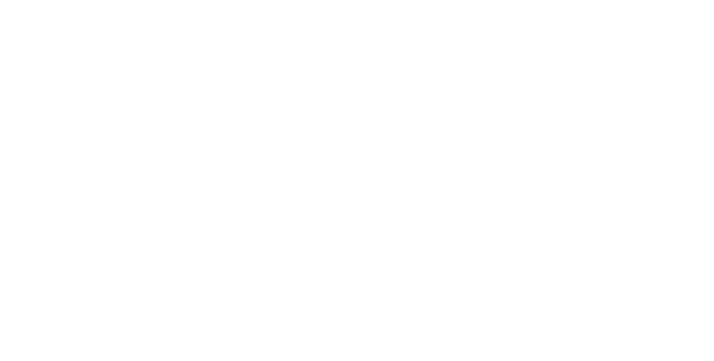

In [36]:
plots(ims, rows=2)

In [37]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [38]:
learn.fit(1e-2, 1)

A Jupyter Widget

  5%|▍         | 17/360 [00:00<00:09, 36.88it/s, loss=0.162]

/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.       0.04474  0.03573  0.98682]                          



Process Process-218:
Process Process-224:
Process Process-221:
Process Process-220:
Process Process-217:
Process Process-201:
Process Process-219:
Process Process-205:
Process Process-222:
Process Process-203:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-206:
Process Process-207:
Process Process-202:
Traceback (most recent call last):
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-208:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in

  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.p

In [39]:
learn.precompute = False

In [40]:
learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

  0%|          | 0/360 [00:03<?, ?it/s, loss=0.0241]

/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.       0.04575  0.03209  0.98779]                         
[ 1.       0.0522   0.02965  0.98828]                         
[ 2.       0.04292  0.0294   0.99023]                         



In [111]:
# learn.fit_gen??

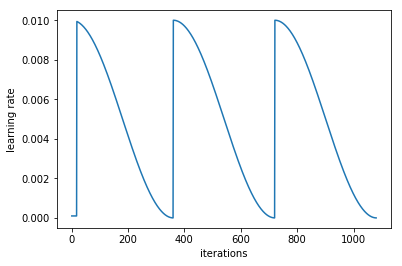

In [41]:
learn.sched.plot_lr()

In [42]:
learn.save('224_lastlayer')

In [43]:
learn.unfreeze()

In [44]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [45]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

  0%|          | 0/360 [00:00<?, ?it/s]

/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.       0.0504   0.03194  0.98926]                         
[ 1.       0.04014  0.02746  0.99219]                         
[ 2.       0.03122  0.02583  0.99219]                         
[ 3.       0.03002  0.02406  0.99121]                         
[ 4.       0.0197   0.0218   0.99268]                         
[ 5.       0.02582  0.02325  0.99268]                         


Process Process-532:
Process Process-527:
Process Process-540:
Process Process-521:
Process Process-526:
Process Process-538:
Process Process-535:
Process Process-541:
Process Process-531:
Process Process-524:
Process Process-537:
Process Process-539:
Process Process-543:
Process Process-542:
Process Process-528:
Process Process-530:
Process Process-525:
Traceback (most recent call last):
Process Process-534:
Process Process-533:
Process Process-523:
Process Process-522:
Process Process-536:
Process Process-529:
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-544:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent c

  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.

  File "/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/dataset.py", line 98, in __getitem__
    self.c = self.get_c()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 41, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 41, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/dataset.py", line 128, in get_x
    super().__init__(transform)
  File "/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/dataset.py", line 104, in get
  File "/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/dataset.py", line 99, in __getitem__
    self.sz = self.get_sz()


  File "/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/transforms.py", line 257, in transform
    x = self.do_transform(x)
  File "/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/transforms.py", line 249, in __call__
    x,y = ((self.transform(x),y) if self.tfm_y==TfmType.NO
  File "/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/transforms.py", line 249, in __call__
    x,y = ((self.transform(x),y) if self.tfm_y==TfmType.NO
  File "/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/transforms.py", line 473, in compose
    im, y =fn(im, y)
  File "/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/transforms.py", line 473, in compose
    im, y =fn(im, y)
  File "/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/transforms.py", line 473, in compose
    im, y =fn(im, y)
  File "/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/transforms.py", line 249, in __call__
    x,y = ((self.transform(x),y) if self.tfm_y==TfmType.NO
  File "/hom

  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 1697, in resize
    self.load()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 1697, in resize
    self.load()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/ImageFile.py", line 212, in load
    s = read(self.decodermaxblock)
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 1697, in resize
    self.load()
  File "/home/bmn/src/ai.learn/fast.ai/fastai/courses/dl1/fastai/transforms.py", line 19, in scale_min
    return im.resize(sz, Image.BILINEAR)
KeyboardInterrupt
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 1697, in resize
    self.load()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/ImageFile.py", line 248, in load
    self.fp.close()
  File "/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 1697,

KeyboardInterrupt: 

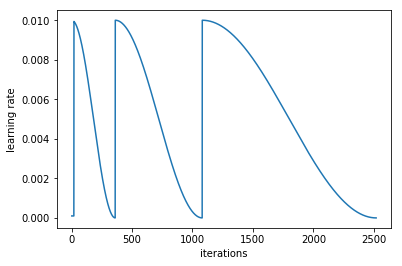

In [83]:
learn.sched.plot_lr()

In [84]:
learn.save('224_all')

In [85]:
log_preds, y = learn.TTA()
accuracy(log_preds, y)

/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.99450000000000005

In [86]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:, 1])

In [87]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[995   5]
 [  6 994]]


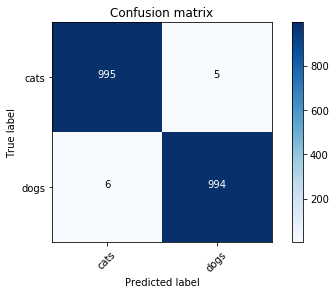

In [88]:
plot_confusion_matrix(cm, data.classes)

most incorrect cats


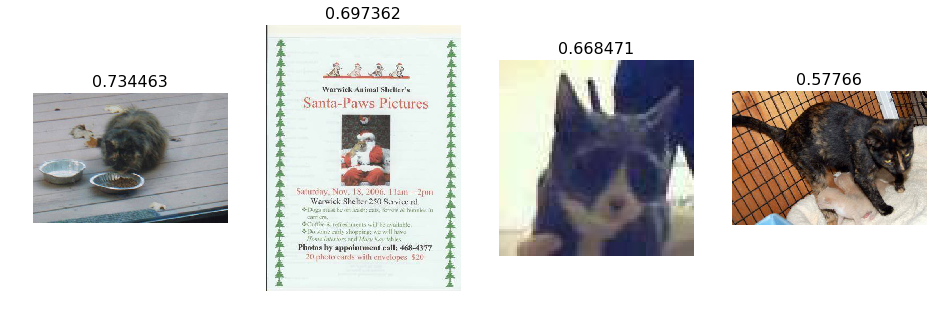

In [107]:
plot_val_with_title(most_by_correct(0, False), "most incorrect cats")

most incorrect dogs


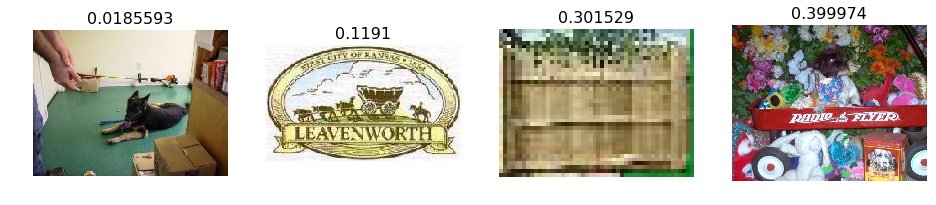

In [108]:
plot_val_with_title(most_by_correct(1, False), "most incorrect dogs")